In [92]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import cv2 as cv
import random as rng
from math import ceil

print(cv.__version__) 

4.11.0


In [93]:
# Create Window
'''source_window = 'Source'
cv.namedWindow(source_window)
cv.imshow(source_window, src)
max_thresh = 255
thresh = 100 # initial threshold
cv.createTrackbar('Canny Thresh:', source_window, thresh, max_thresh, thresh_callback)
thresh_callback(thresh)
cv.waitKey('s')
cv.destroyAllWindows()'''

"source_window = 'Source'\ncv.namedWindow(source_window)\ncv.imshow(source_window, src)\nmax_thresh = 255\nthresh = 100 # initial threshold\ncv.createTrackbar('Canny Thresh:', source_window, thresh, max_thresh, thresh_callback)\nthresh_callback(thresh)\ncv.waitKey('s')\ncv.destroyAllWindows()"

# Functions used

In [94]:
def findDice(image, show_figures=False):
    img_orig = image.copy()

    # Grayscale the image
    img_gray = cv.cvtColor(img_orig, cv.COLOR_BGR2GRAY)
    # Blurring the image
    img_blur = cv.blur(img_gray, (3,3))
    # Detect edges using Canny
    threshold = 200
    canny_output = cv.Canny(img_blur, threshold, threshold * 2)
    # Find Contours
    contours, hierarchy = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # Draw Contours
    img_contours = image.copy()# np.zeros(img_orig.shape, np.uint8)

    dice_rects = []
    for contour in contours:
        # Contour Approximation
        epsilon = 0.01*cv.arcLength(contour, True)
        approx_poly = cv.approxPolyDP(contour, epsilon, True)
        # Fitting/Bounding Rectangle
        rect = cv.minAreaRect(approx_poly)
        box = cv.boxPoints(rect)
        box = np.astype(box, int)
        # Box Area
        box_area = cv.contourArea(box)
        # Filter box by area add to dice_rects then draw the boxes
        if box_area > 800 and box_area < 1500:
            dice_rects.append(box)
            color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
            cv.drawContours(img_contours, [box], 0, color, 3, cv.LINE_8, hierarchy, 0)
    
    if show_figures:
        # Plotting the original image and the boxes found
        plt.subplot(1,2,1)
        plt.imshow(img_orig)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1,2,2)
        plt.imshow(img_contours)
        plt.title('Boxes found')
        plt.axis('off')

        plt.show()

    return dice_rects

def remove_similar_rects(rect_coords):
    rect_coords = np.array(rect_coords)
    rect_centers = np.mean(rect_coords, axis=1)
    
    new_rects = []
    min_squared_distance = 100  # 80 percent the length of a typical dice. Most dice have area of 1000 pixels.
    mask = np.arange(len(rect_coords))
    for i, center in enumerate(rect_centers[:-1]):
        sqaured_distance_to_other_dice = (rect_centers[i+1:,0]-center[0])**2 + (rect_centers[i+1:,1]-center[1])**2
        if np.min(sqaured_distance_to_other_dice) > min_squared_distance:
            new_rects.append(rect_coords[i])
    new_rects.append(rect_coords[-1])
    
    return new_rects

def remove_similar_circs(circ_coords):
    if len(circ_coords) == 0:
        return 0
    circ_coords = np.array(circ_coords)
    centers = circ_coords[:,0:2]
    
    new_dots = []
    min_distance = 8
    mask = np.arange(len(circ_coords))
    for i, center in enumerate(centers[:-1]):
        sqaured_distance_to_other_dice = (centers[i+1:,0]-center[0])**2 + (centers[i+1:,1]-center[1])**2
        if np.min(sqaured_distance_to_other_dice) > min_distance:
            new_dots.append(circ_coords[i])
    new_dots.append(circ_coords[-1])
    
    return len(new_dots)

def crop_boxes(img, coords):
    num_of_crops = len(coords)
    box_coords = []
    for i, coord in enumerate(coords):
        x,y,w,h = cv.boundingRect(coord)
        box_coords.append([[x, y],[x+w, y+h]])

        '''plt.subplot(ceil(num_of_crops/4), 4, i+1)
        plt.imshow(img[y:y+h, x:x+w])
        plt.axis('off')'''
    '''plt.show()'''
    return

def crop_box(img, coords):
    x,y,w,h = cv.boundingRect(coords)
    return img[y:y+h, x:x+w]

def crop_face(coords):
    return

def find_dots(img, show_figures=False):
    img_copy = img.copy()
    # Grayscale the image
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Blurring the image
    img_blur = cv.blur(img_gray, (1,1))
    # Detect edges using Canny
    threshold = 200
    canny_output = cv.Canny(img_blur, threshold, threshold * 2)
    # Find Contours
    contours, hierarchy = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # Draw Contours
    img_contours = np.zeros(img.shape, np.uint8)

    dots_coords = []
    for contour in contours:
        # Contour Approximation
        epsilon = 0.01*cv.arcLength(contour, True)
        approx_poly = cv.approxPolyDP(contour, epsilon, True)
        # Bounding Circle
        (x, y), radius = cv.minEnclosingCircle(contour)
        # Area
        area = cv.contourArea(approx_poly)
        # Filter circles by radius and area
        min_radius = 3
        max_radius = 7
        min_area = min_radius**2 * np.pi
        max_area = max_radius**2 * np.pi
        if (radius > min_radius and radius < max_radius) and (area > min_area and area < max_area):
            dots_coords.append([x, y, radius])
            color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
            cv.drawContours(img_copy, [approx_poly], 0, color, 1, cv.LINE_8, hierarchy, 0)

    if show_figures:
        plt.subplot(1,2,1)
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(img_copy)
        plt.axis('off')

        plt.show()
    return dots_coords

In [95]:
img_test = cv.imread(f'photos/test-images/Dice ({2632}).jpg')
canny = cv.Canny(img_test, 200, 400)

# For checking single image

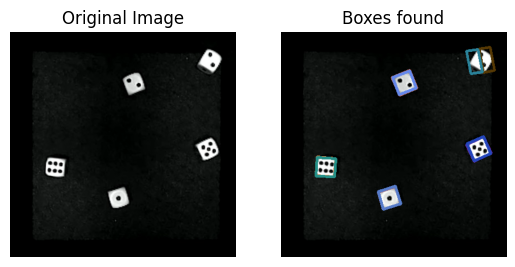

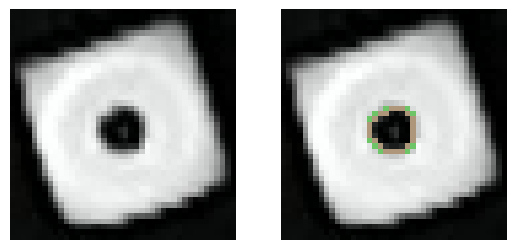

Number of dots found: 1


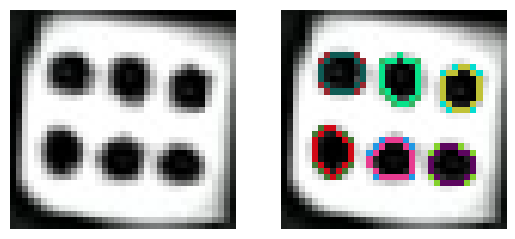

Number of dots found: 6


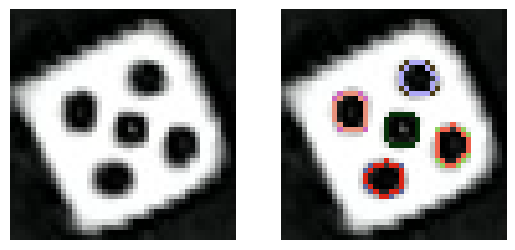

Number of dots found: 5


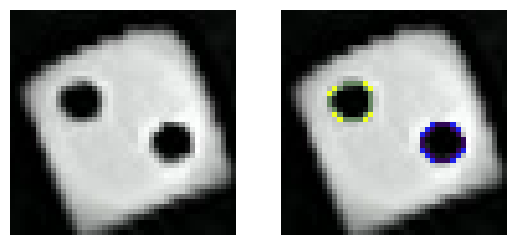

Number of dots found: 2


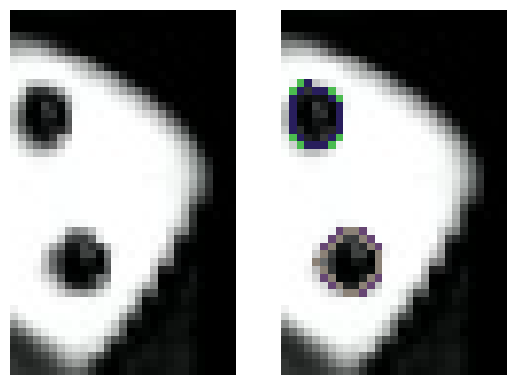

Number of dots found: 2


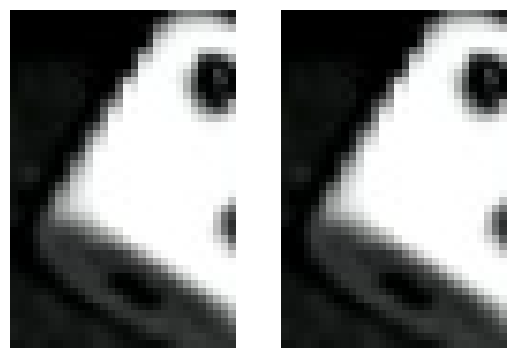

Number of dots found: 0


In [96]:
img = cv.imread(f'photos/test-images/Dice ({2632}).jpg')

box_coords = findDice(img, show_figures=True)

dice_coords = remove_similar_rects(box_coords)
#print('Number of dice found:', len(dice_coords))
crop_boxes(img, dice_coords)

for die_coords in dice_coords:
    die = crop_box(img, die_coords)
    dots_coords = find_dots(die, show_figures=True)
    num_of_dots = remove_similar_circs(dots_coords)
    print('Number of dots found:', remove_similar_circs(dots_coords))

# For checking multiple images

    Image #1


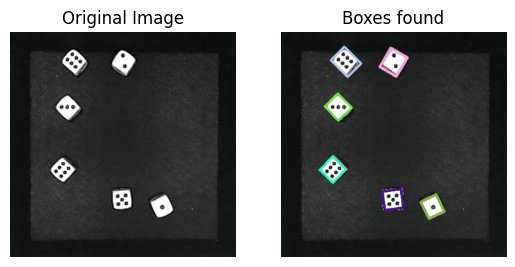

Number of dice: 6


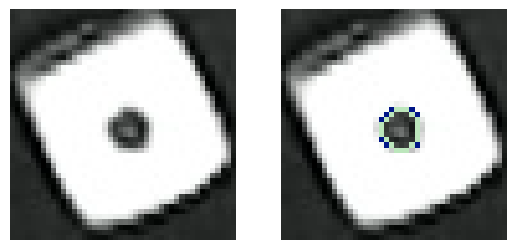

Number of dots on dice: 1


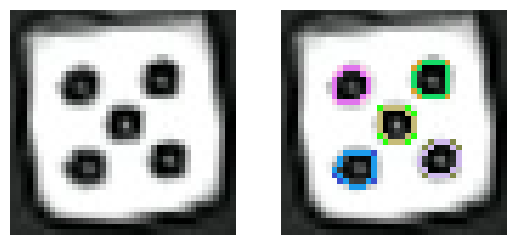

Number of dots on dice: 5


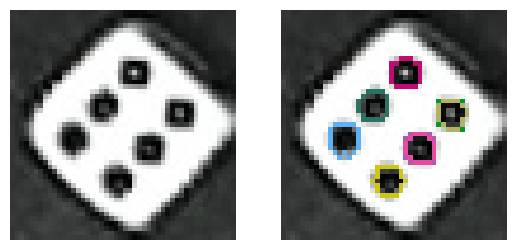

Number of dots on dice: 6


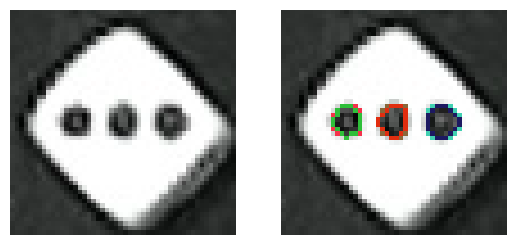

Number of dots on dice: 3


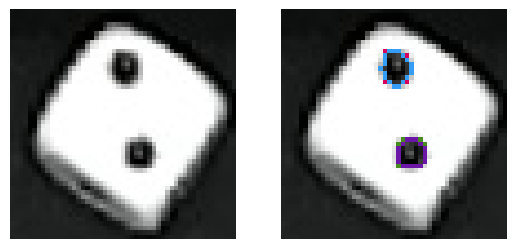

Number of dots on dice: 2


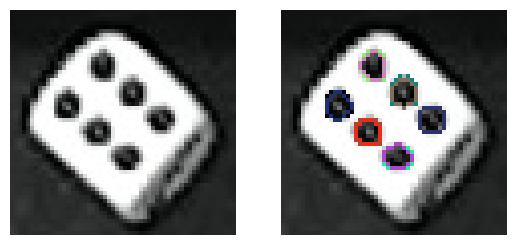

Number of dots on dice: 6


In [97]:
data = []
for i in range(1, 2):
    img = cv.imread(f'photos/test-images/Dice ({i}).jpg')
    print(f"    Image #{i}")
    box_coords = findDice(img, show_figures=True)

    dice_coords = remove_similar_rects(box_coords)
    print('Number of dice:', len(dice_coords))
    crop_boxes(img, dice_coords)

    for die_coords in dice_coords:
        die = crop_box(img, die_coords)
        dots_coords = find_dots(die, show_figures=True)
        num_of_dots = remove_similar_circs(dots_coords)
        if num_of_dots == 0:
            print('zero dots found!')
        if num_of_dots > 6:
            print('more than 6 dots found!')
        data.append(num_of_dots)
        print('Number of dots on dice:', remove_similar_circs(dots_coords))

# For creating the distributions and histogram

In [98]:
data = []
for i in range(1, 11000):
    img = cv.resize(cv.imread(f'photos/test-images/Dice ({i}).jpg'), (410, 410))
    box_coords = findDice(img)

    dice_coords = remove_similar_rects(box_coords)
    crop_boxes(img, dice_coords)

    for die_coords in dice_coords:
        die = crop_box(img, die_coords)
        dots_coords = find_dots(die)
        num_of_dots = remove_similar_circs(dots_coords)
        if num_of_dots == 0:
            print('zero dots found!')
        if num_of_dots > 6:
            print('more than 6 dots found!')
        data.append(num_of_dots)

more than 6 dots found!
zero dots found!
more than 6 dots found!
more than 6 dots found!
more than 6 dots found!
zero dots found!
zero dots found!
zero dots found!
zero dots found!
zero dots found!
zero dots found!
more than 6 dots found!
zero dots found!
zero dots found!
zero dots found!
zero dots found!
zero dots found!
zero dots found!
more than 6 dots found!
more than 6 dots found!


Number 1 Die Count: 12210
Number 2 Die Count: 12144
Number 3 Die Count: 12039
Number 4 Die Count: 12139
Number 5 Die Count: 12677
Number 6 Die Count: 12166
Classification Error: 20
Total number of dice: 73395


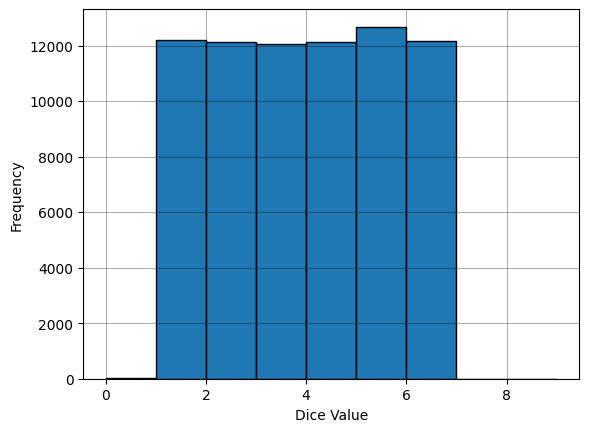

In [99]:
classified = 0
for i in range(1,7):
    count = data.count(i)
    classified += count
    print(f'Number {i} Die Count: {count}')
error = len(data)-classified
print(f'Classification Error: {error}')

print('Total number of dice:', len(data))

plt.hist(data, edgecolor='black', bins=np.arange(0,10))

plt.xlabel("Dice Value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3, color='black')
plt.show()

In [100]:
np.random.rand()

0.6607337533498908

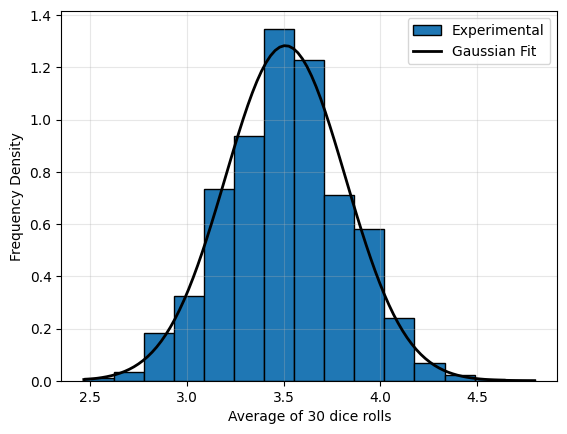

In [128]:
dice_per_group = 30

data_grouped = (np.array(data)[0:len(data)-len(data)%dice_per_group]).reshape((len(data)//dice_per_group, dice_per_group))
ave = np.array([np.mean(x) for x in data_grouped])

# Gaussian Dist
def gauss(x, sigma, mu):
    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-1/2 * ((x-mu)/sigma)**2)

x = np.linspace(np.min(ave), np.max(ave), 100)
mean = np.mean(ave)
sigma = np.std(ave)
gaussian = gauss(x, sigma, mean)

# Plotting
plt.hist(ave, edgecolor='black', bins=15, density=True, label='Experimental')

plt.plot(x, gaussian, color='black', lw=2, label='Gaussian Fit')

plt.grid(alpha=0.3)
plt.xlabel(f"Average of {dice_per_group} dice rolls")
plt.ylabel("Frequency Density")
plt.legend()
plt.show()